In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import csv

import torch
import torch.nn as nn

from tqdm import tqdm

In [3]:
class Actions:
    ''' 
    actions.last() returns the last action taken by the agent.
    actions.next(action) updates the history of actions taken by the agent with the next action
    '''
    def __init__(self, actions):
        self.all_actions = actions
        self.history = [np.random.randint(len(actions))]
        self.last_iter = self.history[-1]
    
    def next(self, action):
        self.history.append(action)

    def last(self):
        return self.last_iter
    
    def next_iter(self, action):
        self.last_iter = action

class Costs:
    '''
    costs.last() returns the last cost incurred by the agent.
    costs.receive(cost) updates the history of costs incurred by the agent with the next cost
    '''
    def __init__(self):
        self.reset()
        self.last_iter = 0

    def receive(self, cost):
        self.accumulated += cost
        self.history.append(cost)

    def last(self):
        return self.history[-1]

    def reset(self):
        self.history = []
        self.accumulated = 0

In [32]:
class Agent:
    def __init__(self, actions, cost_setup, gamma=None):
        self.actions = Actions(actions)
        self.costs = Costs()
        self.cost_ferry, self.cost_alley, self.cost_alley_mult, _ = cost_setup

        self.gamma = np.random.rand() if gamma is None else gamma
        # self.initBrain()
        self.last_turn = 0
        self.neighbours = []

    def initBrain(self):
        self.brain = None
        # initialize a brain, for future using learning techniques.


    def _update_number_playing(self, action):
        return np.array([[1,0], [0,1], [0,0], [1,1]])[action]

    def own_cost_playing(self, action, state):
        n_BD, n_AC = state
        if action == 0:
            return self.cost_ferry + self.cost_alley + self.cost_alley_mult * n_BD
        elif action == 1:
            return self.cost_ferry + self.cost_alley + self.cost_alley_mult * n_AC
        elif action == 2:
            return 2 * self.cost_ferry
        elif action == 3:
            return 2 * self.cost_alley + self.cost_alley_mult * (n_BD + n_AC)

    def own_cost(self, state):
        return self.own_cost_playing(self.actions.last(), state)

    def neighbour_cost(self, state):
        return sum([neighbour.own_cost(state) for neighbour in self.neighbours]) if self.neighbours else 0

    def take_action(self, state):

        # exclude agent from current state numbers
        new_state = -self._update_number_playing(self.actions.last()) + state

        # calculate the cost incurred if the agent takes a certain action (accounting for how the state numbers change afterwards)
        g = self.gamma
        n = len(self.neighbours)+1

        n_if_play_action = [self._update_number_playing(action) + new_state for action in range(4)]

        costs = [
            # ((1-g)+g/n) * self.own_cost_playing(action, state) + g/n * self.neighbour_cost(state) 
            self.own_cost_playing(action, state) + g * self.neighbour_cost(state)
            if n!=0 else self.own_cost_playing(action, state) for action, state in enumerate(n_if_play_action)]

        # take the action with the lowest cost
        action = np.argmin(costs)
        self.actions.next_iter(action)

        return new_state + self._update_number_playing(action)


class CongestionGame:
    '''
    The game class. Initializes the players according to parameters passed on.
    play() runs the game and stores the results.
    run_history stores the results of each stage of the game.
    '''
    def __init__(self, n_agents=60, cost_setup=(15, 2, 0.2, 23), agent_setup=(None, None), order=None, intelligent=False):
        self.actions = ['ABD', 'ACD', 'ABCD', 'ACBD']
        self.cost_setup = cost_setup
        self.intelligent = intelligent
        self.n_BD, self.n_AC = 0, 0

        self._init_agents(n_agents, agent_setup)
        self._iter_reorder = order
        self.stage, self.iteration = 0, 0
        self.run_history = []
        
    def _init_agents(self, n_agents, agent_setup):
        '''initializes agents and sets number taking BD and AC paths'''
        self.n_agents = n_agents
        n_neighbours, gamma = agent_setup
        self.agents = [Agent(self.actions, self.cost_setup, gamma) for _ in range(n_agents)]
        self._update_numbers()

        if n_neighbours is None:
            n_neighbours = np.random.randint(0, n_agents)
        self._set_neighbours(n_neighbours)

    def _update_numbers(self):
        '''updates number taking BD and AC paths'''
        last_actions = [agent.actions.last() for agent in self.agents]

        num_of = lambda action: last_actions.count(self.actions.index(action))
        self.n_BD = num_of('ABD') + num_of('ACBD')
        self.n_AC = num_of('ACD') + num_of('ACBD')
    
    def _set_neighbours(self, n_neighbours):
        '''sets neighbours for each agent assuming agents are in a circle'''
        for i, agent in enumerate(self.agents):
            agent.neighbours = [self.agents[(i + j) % self.n_agents] for j in range(1, n_neighbours + 1)]

    def set_neighbours_individual(self, agent, n_neighbours):
        '''sets neighbours for a single agent'''
        i = self.agents.index(agent)
        agent.neighbours = [self.agents[(i + j) % self.n_agents] for j in range(1, n_neighbours + 1)]

    def _num_agents_taking_action(self):
        '''returns number of agents taking each action'''
        actions = [agent.actions.last() for agent in self.agents]
        return [actions.count(action) for action in range(4)]

    def play(self, n_stages=1, n_iterations=1, verbose=True):
        '''plays the game for n_stages and n_iterations'''

        stage_iter = tqdm(range(n_stages)) if verbose else range(n_stages)

        for _ in stage_iter:
            self.stage += 1
            self.iteration = 0
            for _ in range(n_iterations):
                self.iteration += 1
                last_actions = self._num_agents_taking_action()

                # decide order of playing
                if self._iter_reorder is not None:
                    self._iter_reorder(self.agents)

                # take actions
                for turn, agent in enumerate(self.agents):
                    agent.last_turn = turn
                    self.n_BD, self.n_AC = agent.take_action([self.n_BD, self.n_AC])

                # update costs within iteration, to decide ordering for next iteration
                for agent in self.agents:
                    agent.costs.last_iter = agent.own_cost([self.n_BD, self.n_AC])

                # check if converged (not exactly, but close enough)
                if self._num_agents_taking_action() == last_actions:
                    break
            
            # record the action taken by each agent
            for agent in self.agents:
                agent.actions.next(agent.actions.last())

            # update state numbers according to the action taken
            self._update_numbers()

            # record the cost for each agent
            stage_cost = 0
            for agent in self.agents:
                cost = agent.own_cost([self.n_BD, self.n_AC])
                agent.costs.receive(cost)
                stage_cost += cost
            
            # update gamma and neighbours for next stage
            if self.intelligent:
                for agent in self.agents:
                    if agent.costs.last() > self.cost_setup[-1]:
                        agent.gamma = agent.gamma/4.0
                        self.set_neighbours_individual(agent, max(0, len(agent.neighbours)//4))
                    else:
                        agent.gamma = min(1, agent.gamma*2.0)
                        self.set_neighbours_individual(agent, int(min(self.n_agents, len(agent.neighbours)*2)))
            
            self.run_history.append([self.iteration, self._num_agents_taking_action(), stage_cost/self.n_agents, [[agent.gamma, len(agent.neighbours), agent.costs.last()] for agent in self.agents]])

In [4]:
def accumulated_cost_order(agents):
    '''orders agents by accumulated cost'''
    agents.sort(key=lambda agent: agent.costs.accumulated, reverse = True)

def last_cost_order(agents):
    '''orders agents by cost of action in last iteration'''
    agents.sort(key=lambda agent: agent.costs.last_iter, reverse = True)

def last_turn_order(agents):
    '''orders agents by turn in last iteration'''
    agents.sort(key=lambda agent: agent.last_turn, reverse = True)

## Playground

### First params

In [5]:
n_neighbours = 59
gamma = 0.9
game = CongestionGame(agent_setup=(n_neighbours, gamma), order=last_cost_order)
game.play(n_stages=10, n_iterations=100)

print(*game.run_history, sep='\n')

100%|██████████| 10/10 [00:02<00:00,  3.85it/s]

[2, [15, 15, 11, 19], 22.97333333333329]
[2, [0, 0, 19, 41], 23.44000000000002]
[2, [0, 0, 16, 44], 23.83999999999998]
[3, [0, 0, 25, 35], 23.0]
[3, [0, 0, 19, 41], 23.44000000000002]
[4, [0, 0, 16, 44], 23.839999999999982]
[3, [0, 0, 25, 35], 23.0]
[3, [0, 0, 19, 41], 23.44000000000002]
[4, [0, 0, 16, 44], 23.839999999999982]
[3, [0, 0, 25, 35], 23.0]


In [ ]:
# for scaled cost
record = []

gamma_range = list(np.arange(0, 0.8, 0.1)) + list(np.arange(0.8, 1.01, 0.02))
neigh_range = list(range(0, 60, 5)) + [59]

pbar = tqdm(neigh_range)
for n_neighbours in pbar:
    for gamma in gamma_range:
        pbar.set_description(f'gamma = {gamma:.2f}, n = {n_neighbours}')
        game = CongestionGame(agent_setup=(n_neighbours, gamma), order=last_cost_order)
        game.play(n_stages=10, n_iterations=100, verbose=False)
        min_cost = min([stage[2] for stage in game.run_history])
        record.append([n_neighbours, gamma, min_cost])

In [ ]:
# export as a csv file, the record
with open('record_scaledcost.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(record)

In [33]:
# for unscaled cost
record = []

gamma_range = np.arange(0, 1.01, 0.1)
neigh_range = list(range(0, 60, 5)) + [59]

pbar = tqdm(neigh_range)
for n_neighbours in pbar:
    for gamma in gamma_range:
        pbar.set_description(f'gamma = {gamma:.2f}, n = {n_neighbours}')
        game = CongestionGame(agent_setup=(n_neighbours, gamma), order=last_cost_order)
        game.play(n_stages=10, n_iterations=100, verbose=False)
        min_cost = min([stage[2] for stage in game.run_history])
        record.append([n_neighbours, gamma, min_cost])

gamma = 1.00, n = 59: 100%|██████████| 13/13 [01:37<00:00,  7.48s/it]


In [34]:
# export as a csv file, the record
with open('record_unscaledcost.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(record)

### Vishnu params

Min (over stages) of avg (over players) of cost, for different initializations:
Checking the centralized scheduler actions results over the parameter space.

In [6]:
record = []

gamma_range = np.arange(0, 1.01, 0.1)
neigh_range = list(range(0, 200, 20)) + [199]

pbar = tqdm(neigh_range)
for n_neighbours in pbar:
    for gamma in gamma_range:
        pbar.set_description(f'gamma = {gamma:.2f}, n = {n_neighbours}')
        game = CongestionGame(cost_setup=(40,15,0.1,65), n_agents=200, agent_setup=(n_neighbours, gamma), order=last_cost_order)
        game.play(n_stages=10, n_iterations=100, verbose=False)
        min_cost = min([stage[2] for stage in game.run_history])
        record.append([n_neighbours, gamma, min_cost])
min([stage[2] for stage in game.run_history])

gamma = 1.00, n = 199: 100%|██████████| 11/11 [08:48<00:00, 48.03s/it]


64.375

In [7]:
# export as a csv file, the record
with open('record_road_vish_intel.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(record)

Intelligent play with random initializations

In [ ]:
record = []

runs = range(1)
pbar = tqdm(runs)
for _ in pbar:
    game = CongestionGame(cost_setup=(40,15,0.1,65), n_agents=200, order=last_cost_order, intelligent=True)
    game.play(n_stages=10, n_iterations=100, verbose=False)
    avg_cost = np.mean([stage[2] for stage in game.run_history])
    record.append([n_neighbours, gamma, avg_cost])
min([stage[2] for stage in game.run_history])

In [33]:
game = CongestionGame(cost_setup=(40,15,0.1,65), n_agents=200, intelligent=True)
game.play(n_stages=50, n_iterations=10)

100%|██████████| 50/50 [00:54<00:00,  1.10s/it]


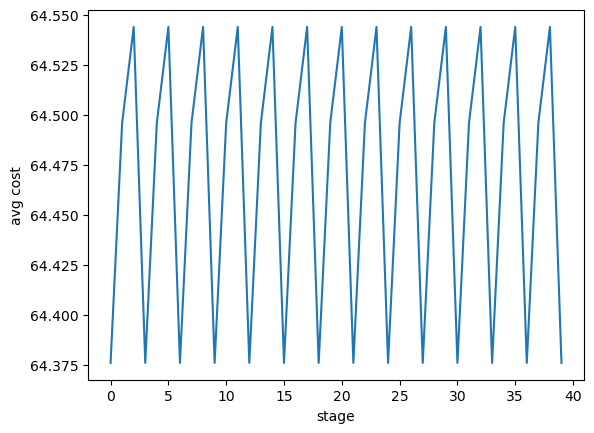

In [48]:
n_iter = [stage[2] for stage in game.run_history[10:]]
# plot n_iter as a function of stage
plt.plot(n_iter)
plt.xlabel('stage')
plt.ylabel('avg cost')
plt.show()

In [49]:
np.mean(n_iter)

64.46960000000013

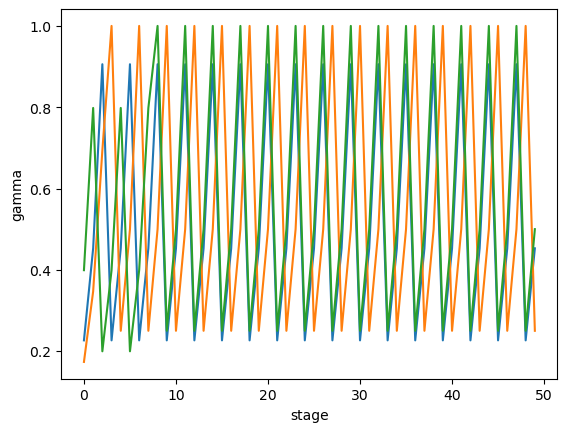

In [47]:
g = np.array([[stage[3][i][0] for stage in game.run_history] for i in [0,1,3]])
# plot n_iter as a function of stage
plt.plot(g.transpose())
plt.xlabel('stage')
plt.ylabel('gamma')
plt.show()